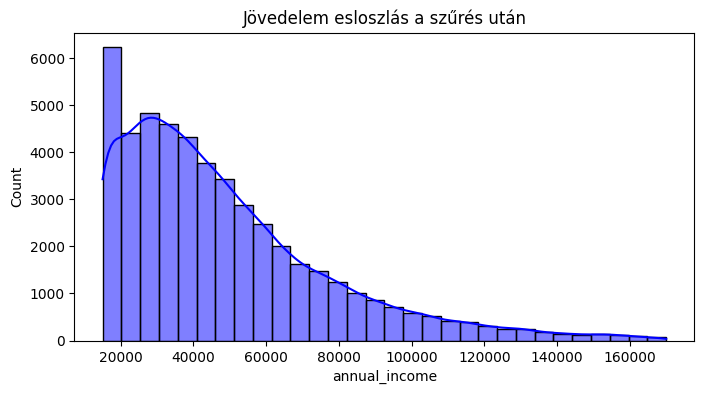

Epoch 1/50


d:\Gepiebeadando\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8729 - loss: 0.2889 - val_accuracy: 0.9001 - val_loss: 0.2299
Epoch 2/50
 811/1238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8939 - loss: 0.2391

KeyboardInterrupt: 

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


df = pd.read_csv('Loan_approval_data_2025.csv')
df.columns = df.columns.str.strip()
df = df.dropna()
df['Net_Surplus'] = df['savings_assets'] - df['current_debt']

min_val, max_val = df['annual_income'].quantile([0.01, 0.99])
df_filtered = df[df['annual_income'].between(min_val, max_val)].copy()

plt.figure(figsize=(8, 4))
sns.histplot(df_filtered['annual_income'], bins=30, kde=True, color='blue')
plt.title('Jövedelem esloszlás a szűrés után')
plt.show()


if df_filtered['loan_status'].dtype == 'object':
    df_filtered['loan_status'] = df_filtered['loan_status'].apply(lambda x: 1 if x == 'Approved' else 0)


X = df_filtered.drop(['loan_status', 'customer_id'], axis=1)
y = df_filtered['loan_status']

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Hiba a tanulásban')
plt.plot(history.history['val_loss'], label='Hiba a validációban')
plt.title('Hiba csökkenése')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Tanulási pontosság')
plt.plot(history.history['val_accuracy'], label='Validációs pontosság')
plt.title('Pontosság javulása')
plt.legend()
plt.show()

print("Eredmények")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.ylabel('Valós érték')
plt.xlabel('Tippelt érték')
plt.show()